### Inits

In [1]:
# import pylab
from pylab import *

#Matplotlib defs
import matplotlib
matplotlib.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

#Numpy
import numpy as np
from numpy.random import multivariate_normal


from scipy import stats
from scipy import stats
import scipy.integrate as integrate
from scipy.interpolate import interp1d as int1d
from scipy.special import erfc as erfc
from scipy.signal import savgol_filter
from scipy.spatial.distance import cdist


import random

import seaborn as sns

from tqdm.notebook import *

import arviz as az

#Astropy
from astropy.cosmology import Planck15 as cosmo
from astropy.cosmology import z_at_value
from astropy.coordinates import SkyCoord
from astropy.coordinates import CartesianRepresentation
import astropy.units as u
from astropy.io import fits
from astropy import constants as const

#GetDist
from getdist import plots, MCSamples
import getdist

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

### Data Read

In [3]:
hdul = fits.open('DR7.fits')
data = hdul[1].data  # First extension is the table!
ra = data['RA']
dec = data['DEC']
z = data['REDSHIFT']
mass = data['LOGBH']
dmass = data['LOGBH_ERR']


#define restricted parameters and indicators
m_min=8
m_max=13
z_max=2.5
z_min=0.4
ra_min=120
ra_max=240
dec_min=10
dec_max=50

inds=(mass<m_max) & (mass>m_min) & (z < z_max) & (dec > dec_min) & (dec < dec_max) & (ra > ra_min) & (ra < ra_max) & (z > z_min) 

# restricted arrays
z_new=z[inds]
dec_new=dec[inds]
ra_new=ra[inds]
mass_new=mass[inds]
dmass_new=dmass[inds]
DC_new=cosmo.comoving_distance(z_new)
DA_new=cosmo.angular_diameter_distance(z_new)
QSO_coord = SkyCoord(ra_new*u.degree, dec_new*u.degree, frame='icrs', distance = DC_new)



# Duty-cycle digitized
lam06=np.loadtxt(open('../digi/lam06.csv'), delimiter=",")
lam03=np.loadtxt(open('../digi/lam03.csv'), delimiter=",")
minL=np.loadtxt(open('../digi/minL.csv'), delimiter=",")
lam03=np.vstack((lam03,[lam03[-1,0]+5,lam03[-1,1]]))
lam06=np.vstack((lam06,[lam06[-1,0]+5,lam06[-1,1]]))
minL=np.vstack((minL,[minL[-1,0]+5,minL[-1,1]]))
intlam06=int1d(lam06[:,0]-0.02,10**lam06[:,1],kind=1)
intlam03=int1d(lam03[:,0]-0.01,10**lam03[:,1],kind=1)
intminL=int1d(minL[:,0],10**minL[:,1],kind=1)

lamlis=intminL(mass_new)
# lamlis=intlam06(mass_new)

### Functions and constants

In [4]:
theta_BH_const=(5*const.G*const.M_sun*u.rad/(const.c)**2).to(u.microarcsecond*u.Mpc)
def theta_BH(logM,DA):
    return theta_BH_const*10**logM/DA


# M_sig relation from Ho & Kormendy 2013 in units of km/sec
def MBH_to_sig(logM):
    return (10**(logM-9)/0.31)**(1/4.38)*200

grav_BH_const=(const.G*const.M_sun*u.rad/(u.km/u.s)**2).to(u.arcsecond*u.Mpc)
def grav_BH(logM,DA):
    return grav_BH_const*10**logM/DA/(MBH_to_sig(logM))**2

#Co-moving to Angular Diameter distance
cmd_to_add=int1d(logspace(-2,4.1,200),cosmo.angular_diameter_distance(np.array([z_at_value(cosmo.comoving_distance,x*u.Mpc) for x in logspace(-2,4.1,200)])).value)

In [5]:
lis=np.linspace(0,4,1000)
DA_max=np.max(cosmo.angular_diameter_distance(lis)).value #Mpc
lis=lis[:np.argmax(cosmo.angular_diameter_distance(lis))]
DAt_lis=cosmo.angular_diameter_distance(lis).value
DCt_lis=cosmo.comoving_distance(lis)
DCt_lis=np.append(DCt_lis,cosmo.comoving_distance(lis[-1])).value
DAt_lis=np.append(DAt_lis,DA_max)
add_to_cmd=int1d(DAt_lis,DCt_lis)


# Analytic try
We will try to estimate the mass function etc. using an analytic method.

Say that the quasar measurments are given by
$$f(M,\vec{r})=\sum_{i}\delta^{(3)}(\vec{r}-\vec{r}_i)\delta(\log(M/M_i))$$
The number of quasars closer than $R_{\rm max}$ to an observer located at $\vec{r}$ is given by
$$N(\vec{r})=\int_{r'<R_{\rm max}} d^3r'f(M,\vec{r}+\vec{r}').$$
If we average $N(\vec{r})$ over some ball defined by $R_{\rm obs}$, we find
$$\bar{N}_{R_{\rm obs}}=\frac{3}{4\pi R_{\rm obs}^3}\int_{r<R_{\rm obs}}d^3r\int_{r'<R_{\rm max}} d^3r'f(M,\vec{r}+\vec{r}').$$
This is simply given by
$$\bar{N}_{R_{\rm obs}}=\sum_i\frac{V_{i,\rm obs}}{V_{\rm obs}}\delta(\log(M/M_i)),$$
where $V_{i,\rm obs}$ is the volume of the intersection between a ball of radius $R_{\rm obs}$ and a ball of radius $R_{\rm max}$ separated by a distance $r_i$. 

If we want to restrict the discussion to quasars with angular size larger than $\theta$, we get that the mean number of such quasars is given by
$$\bar{N}_{R_{\rm obs}}=\sum_i\frac{\tilde{V}_{i,\rm obs}}{V_{\rm obs}},$$
where $\tilde{V}_{i,\rm obs}$ is the volume of the intersection between a ball of radius $R_{\rm obs}$ and a ball of radius $R_i$ separated by a distance $r_i$, where we defined $R_i$ as the minimum of $R_{\rm max}$ and the co-moving distance that correponds with an angular diameter distance defined by

$$D_A=\frac{5 G M}{\theta c^2}$$

In [6]:
# RO is a point
# RQ and DQO are arrays of smae length

# two balls arent apprt?
def isnt_appart(R1,R2,D):
    return (D<(R1+R2))


# one ball is contained in the other?
def Is_inside(RO,RQ,DQO):
    return RO+DQO<RQ, RQ+DQO<RO

#Volume of a ball    
def vol_1(R):
    return 4*np.pi*R**3/3

# Tthe volume of a lense (non-trivial intersection of two balls) is given by
def co_volume_2(R1,R2,D):    
    return np.pi*((R1+R2-D)**2)*(D**2-3*(R1-R2)**2+2*D*(R1+R2))/12/D


    

# combiine all cases above    
def co_volume_2_cases(RO,RQ,DQO):
    # keep those who are not appart
    QO_isnt_apt_inds=isnt_appart(RO,RQ,DQO);
    RQt=RQ[QO_isnt_apt_inds]
    DQOt=DQO[QO_isnt_apt_inds]
    
    vol_2_temp=np.zeros(len(RQt))

    
    # find simple cases and fill array
    O_in_Q_inds, Q_in_O_inds= Is_inside(RO,RQt,DQOt)
    vol_2_temp[O_in_Q_inds]=np.full(np.sum(O_in_Q_inds),vol_1(RO))
    vol_2_temp[Q_in_O_inds]=vol_1(RQt[Q_in_O_inds])
    
    # find complicated cases
    QO_not_in=np.logical_not((O_in_Q_inds) + (Q_in_O_inds))
    vol_2_temp[QO_not_in]=co_volume_2(RO,RQt[QO_not_in],DQOt[QO_not_in])
    return vol_2_temp, QO_isnt_apt_inds, O_in_Q_inds, Q_in_O_inds, QO_not_in, RQt, DQOt

# # For the calculatio of the VQQ matrix we also calculate the 2-volume for |R1|=|R2|=|DQQ|=NQQ 
# # This function gets only pairs that aren't disjoint
# def co_volume_2_vector(Ra,Rb,DQQ):
#     vol_2_temp=np.zeros(len(Ra))

#     # find simple cases and fill array
#     a_in_b_inds, b_in_a_inds= Is_inside(Ra,Rb,DQQ)
#     vol_2_temp[a_in_b_inds]=np.full(np.sum(a_in_b_inds),vol_1(Ra[a_in_b_inds]))
#     vol_2_temp[b_in_a_inds]=np.full(np.sum(b_in_a_inds),vol_1(Ra[b_in_a_inds]))
    
#     # find complicated cases
#     QQ_not_in=np.logical_not((a_in_b_inds) + (b_in_a_inds))
#     vol_2_temp[QQ_not_in]=co_volume_2(Ra[QQ_not_in],Rb[QQ_not_in],DQQ[QQ_not_in])
#     return vol_2_temp, QO_isnt_apt_inds, O_in_Q_inds, Q_in_O_inds, QO_not_in, RQt, DQOt

# Three spheres

We are interested in a function that takes 3 **non-disjoint** balls and returns the volume of intersection. 
The computation of the 2 and 3 volumes uses a lot of similar  indgediants so we shall do both together.
The input of the function are:
$$ 
R_{\rm O}=\text{radius of observes ball}.\\
R_{Q}=\text{array of quasars radius, length }N_Q.\\
D_{QO}=\text{array of quasar - observer distances, length }N_Q.\\
D_{QQ}=\text{array of quasar - quasar distances, shape }N_Q\times N_Q.\\
V_{QQ}=\text{co-volume of quasar - quasar distances pairs, shape }N_Q\times N_Q.
$$
Implamentaion steps:
1. Find __isnt_apt_inds__, indecies for quasrs that arent disjoint from observer using __isnt_appart(RO,RQ,DQO)__
2. Make smaller arrays: **RQ[isnt_apt_inds]**, **DQO[isnt_apt_inds]**, **DQQ[isnt_apt_inds,isnt_apt_inds]**
3. 

In [18]:
def eps_q_w(R1,R2,R3,D1,D2,D3):
    R1s=R1**2
    R2s=R2**2
    R3s=R3**2
    D1s=D1**2
    D2s=D2**2
    D3s=D3**2
    
    eps1=(R2s-R3s)/D1s
    eps2=(R3s-R1s)/D2s
    eps3=(R1s-R2s)/D3s
    
    q1=D1*(D2s+D3s-D1s+R2s+R3s-2*R1s+eps1*(D2s-D3s))
    q2=D2*(D3s+D1s-D2s+R3s+R1s-2*R2s+eps2*(D3s-D1s))
    q3=D3*(D1s+D2s-D3s+R1s+R2s-2*R3s+eps3*(D1s-D2s))
    
    w2=(R1s*D1s+R2s*D2s+R3s*D3s)*(D1s+D2s+D3s)-2*(R1s*D1s**2+R2s*D2s**2+R3s*D3s**2)+D1s*D2s*D3s*(eps1*eps2+eps2*eps3+eps3*eps1-1)
    
    return eps1, eps2, eps3, q1, q2, q3, w2
    
def vol_3_topo_d(R1,R2,R3,D1,D2,D3,eps1, eps2, eps3, q1, q2, q3, w2):
    R1s=R1**2
    R2s=R2**2
    R3s=R3**2
    D1s=D1**2
    D2s=D2**2
    D3s=D3**2
    w=np.sqrt(w2)
    
    atan1=np.arctan2(2*w,q1)
    atan2=np.arctan2(2*w,q2)
    atan3=np.arctan2(2*w,q3)
    
    atan1m=np.arctan2(w*D2/R1,q2/(1-eps2))
    atan2m=np.arctan2(w*D3/R2,q3/(1-eps3))
    atan3m=np.arctan2(w*D1/R3,q1/(1-eps1))
    
    atan1p=np.arctan2(w*D3/R1,q3/(1+eps3))
    atan2p=np.arctan2(w*D1/R2,q1/(1+eps1))
    atan3p=np.arctan2(w*D2/R3,q2/(1+eps2))

#     atan1m=np.arctan2(w*D2/R1*(1-eps2),q2)
#     atan2m=np.arctan2(w*D3/R2*(1-eps3),q3)
#     atan3m=np.arctan2(w*D1/R3*(1-eps1),q1)
    
#     atan1p=np.arctan2(w*D3/R1*(1+eps3),q3)
#     atan2p=np.arctan2(w*D1/R2*(1+eps1),q1)
#     atan3p=np.arctan2(w*D2/R3*(1+eps2),q2)
    
    U1=D1*(R2s+R3s-D1s*(1/6-eps1**2/2))*atan1/2
    U2=D2*(R3s+R1s-D2s*(1/6-eps2**2/2))*atan2/2
    U3=D3*(R1s+R2s-D3s*(1/6-eps3**2/2))*atan3/2
    
    T1=2*R1**3*(atan1m+atan1p)/3
    T2=2*R2**3*(atan2m+atan2p)/3
    T3=2*R3**3*(atan3m+atan3p)/3
    
    return w/6+T1+T2+T3-U1-U2-U3

def vol_3_topo_ac(R1,R2,R3,D1,D2,D3):
    vol_3_temp=np.zeros(len(R1))
    
    R1s=R1**2
    R2s=R2**2
    R3s=R3**2
    D1s=D1**2
    D2s=D2**2
    D3s=D3**2
    
    S=(D1+D2+D3)/2
    S1=(D1+R2+R3)/2
    S2=(D2+R3+R1)/2
    S3=(D3+R1+R2)/2
    
    A=np.sqrt(S*(S-D1)*(S-D2)*(S-D3))
    A1=np.sqrt(S1*(S1-D1)*(S1-R2)*(S1-R3))
    A2=np.sqrt(S2*(S2-D2)*(S2-R3)*(S2-R1))
    A3=np.sqrt(S3*(S3-D3)*(S3-R1)*(S3-R2))
    
    L1p=(D2s-D3s+R2s-R3s)**2+16*(A+A1)**2-4*D1s*R1s
    L1m=L1p-16*4*A*A1
    L2p=(D3s-D1s+R3s-R1s)**2+16*(A+A2)**2-4*D2s*R2s
    L2m=L2p-16*4*A*A2
    L3p=(D1s-D2s+R1s-R2s)**2+16*(A+A3)**2-4*D3s*R3s
    L3m=L3p-16*4*A*A3
    
    L1p_inds=L1p>0
    L1m_inds=L1m>0
    L2p_inds=L2p>0
    L2m_inds=L2m>0
    L3p_inds=L3p>0
    L3m_inds=L3m>0
    
    
    all_but_1_pos=np.logical_not(L1p_inds+L1m_inds)*L2p_inds*L2m_inds*L3p_inds*L3m_inds
    all_but_2_pos=np.logical_not(L2p_inds+L2m_inds)*L3p_inds*L3m_inds*L1p_inds*L1m_inds
    all_but_3_pos=np.logical_not(L3p_inds+L3m_inds)*L1p_inds*L1m_inds*L2p_inds*L2m_inds
    
    all_but_1_neg=L1p_inds*L1m_inds*np.logical_not(L2p_inds+L2m_inds)*np.logical_not(L3p_inds+L3m_inds)
    all_but_2_neg=L2p_inds*L2m_inds*np.logical_not(L3p_inds+L3m_inds)*np.logical_not(L1p_inds+L1m_inds)
    all_but_3_neg=L3p_inds*L3m_inds*np.logical_not(L1p_inds+L1m_inds)*np.logical_not(L2p_inds+L2m_inds)
    
    
    vol_3_temp[all_but_1_pos]=co_volume_2(R2[all_but_1_pos],R3[all_but_1_pos],D1[all_but_1_pos])
    vol_3_temp[all_but_2_pos]=co_volume_2(R3[all_but_2_pos],R1[all_but_2_pos],D2[all_but_2_pos])
    vol_3_temp[all_but_3_pos]=co_volume_2(R1[all_but_3_pos],R2[all_but_3_pos],D3[all_but_3_pos])
    
    Rit=R1[all_but_1_neg]
    Rjt=R2[all_but_1_neg]
    Rkt=R3[all_but_1_neg]
    Djt=D2[all_but_1_neg]
    Dkt=D3[all_but_1_neg]
    vol_3_temp[all_but_1_neg]=co_volume_2(Rit,Rjt,Dkt)+co_volume_2(Rkt,Rit,Djt)-vol_1(Rit)
    Rit=R2[all_but_2_neg]
    Rjt=R3[all_but_2_neg]
    Rkt=R1[all_but_2_neg]
    Djt=D3[all_but_2_neg]
    Dkt=D1[all_but_2_neg]
    vol_3_temp[all_but_2_neg]=co_volume_2(Rit,Rjt,Dkt)+co_volume_2(Rkt,Rit,Djt)-vol_1(Rit)
    Rit=R3[all_but_3_neg]
    Rjt=R1[all_but_3_neg]
    Rkt=R2[all_but_3_neg]
    Djt=D1[all_but_3_neg]
    Dkt=D2[all_but_3_neg]
    vol_3_temp[all_but_3_neg]=co_volume_2(Rit,Rjt,Dkt)+co_volume_2(Rkt,Rit,Djt)-vol_1(Rit)
    
    return vol_3_temp

    
def vol_3_topo(R1,R2,R3,D1,D2,D3):
    eps1, eps2, eps3, q1, q2, q3, w2 =eps_q_w(R1,R2,R3,D1,D2,D3)
    vol_3_temp=np.zeros(len(R1))
    
    # Separate topology d from the rest
    case_d_inds=w2>0
    not_d_inds=np.logical_not(case_d_inds)
    
    vol_3_temp[case_d_inds]=vol_3_topo_d(R1[case_d_inds],R2[case_d_inds],R3[case_d_inds],
                                         D1[case_d_inds],D2[case_d_inds],D3[case_d_inds],eps1[case_d_inds], eps2[case_d_inds], eps3[case_d_inds], q1[case_d_inds], q2[case_d_inds], q3[case_d_inds], w2[case_d_inds])
    
    vol_3_temp[not_d_inds]=vol_3_topo_ac(R1[not_d_inds],R2[not_d_inds],R3[not_d_inds],D1[not_d_inds],D2[not_d_inds],D3[not_d_inds])
    
    return vol_3_temp

In [56]:
def co_vol_23(RO,RQ,DQO,DQQ):
    
    # Calculate 2-balls volume and relevant indecies
    vol_2_temp, QO_isnt_apt_inds, O_in_Q_inds, Q_in_O_inds, QO_not_in, RQt, DQOt = co_volume_2_cases(RO,RQ,DQO)
    
    # Keep only relevant QQ pairs (QO aren't disjoint)
    DQQt=DQQ[QO_isnt_apt_inds][:,QO_isnt_apt_inds]
    
    # make a 2d arry out of vol_2
    vol_2_arr=np.full(DQQt.shape,vol_2_temp)
    
    # Find QQ pairs that aren't disjoint
    RQt_arr=np.full(DQQt.shape,RQt)
    QQ_isnt_apt_inds=isnt_appart(RQt_arr,np.transpose(RQt_arr),DQQt)
    

    
    # We will not sum over all i&j since we can sum over j>i and use our knowledge of N (c.f. eq. 8 in my note).
    # We therefore define an upper triangular boolean matrix (keeps only j>i)
    upper_tri_bol=np.triu(np.full(DQQt.shape,True),1)
    
    # initial empty volume arr
    vol_3_temp=np.zeros(DQQt.shape)

    ### Starting to fill array case by case
    
    # When RO ⊂ Qᵢ VO_{ij}=VO_j (and also i<-->j)
    vol_3_temp[O_in_Q_inds]=vol_2_arr[O_in_Q_inds]
    vol_3_temp[:,O_in_Q_inds]=np.transpose(vol_3_temp[O_in_Q_inds])
    # keep track of what still should be filled 
    O_in_Q_arr=np.full(DQQt.shape,O_in_Q_inds)
    not_O_in_Q_inds=np.logical_not(O_in_Q_arr+np.transpose(O_in_Q_arr))
    good_inds=not_O_in_Q_inds*QQ_isnt_apt_inds*upper_tri_bol
    
    # When Qⱼ ⊂ Qᵢ VO_{ij}=VO_j etc.
    # Find (relevant) QQ pairs that are inside one another
    temp_vol= vol_3_temp[good_inds]
    i_in_j_inds, j_in_i_inds= Is_inside(RQt_arr[good_inds],np.transpose(RQt_arr)[good_inds],DQQt[good_inds])
    temp_vol[i_in_j_inds]=vol_2_arr[good_inds][i_in_j_inds]
    temp_vol[j_in_i_inds]=np.transpose(vol_2_arr)[good_inds][j_in_i_inds]
    vol_3_temp[good_inds]=temp_vol
    # Update what's left to be filled
    temp_inds=good_inds[good_inds]
    temp_inds[j_in_i_inds+i_in_j_inds]=np.full(np.sum(j_in_i_inds+i_in_j_inds),False)
    good_inds[good_inds]=temp_inds
    
    # When [(Qᵢ⊂ RO)∩¬(RO⊂ Qⱼ)]∪[(Qⱼ⊂ RO)∩¬(RO⊂ Qᵢ)], we must calculate V_{ij}, the intersection of Qᵢ and Qⱼ
    Qi_in_O_not_in_Qj=np.outer(Q_in_O_inds,np.logical_not(O_in_Q_inds))
    Vij_bol_arr=(Qi_in_O_not_in_Qj+np.transpose(Qi_in_O_not_in_Qj))
    # and fill the relevant entries of the array
    vol_3_temp[Vij_bol_arr*good_inds]=co_volume_2(RQt_arr[Vij_bol_arr*good_inds],np.transpose(RQt_arr)[Vij_bol_arr*good_inds],DQQt[Vij_bol_arr*good_inds])
    # Update what's left to be filled
    good_inds[Vij_bol_arr]=False*good_inds[Vij_bol_arr]
    
    ## And to the complicated topologies
    long_R1=RQt_arr[good_inds]
    long_R2=np.transpose(RQt_arr)[good_inds]
    long_RO=0*long_R2+RO
    
    DQOt_arr=np.full(DQQt.shape,DQOt)
    long_DQ1=DQOt_arr[good_inds]
    long_DQ2=np.transpose(DQOt_arr)[good_inds]
    
    long_DQQ=DQQt[good_inds]
    
    vol_3_temp[good_inds]=vol_3_topo(long_RO,long_R1,long_R2,long_DQQ,long_DQ2,long_DQ1)
    
    
    return vol_3_temp[upper_tri_bol], vol_2_temp#, long_RO,long_R1,long_R2,long_DQQ,long_DQ2,long_DQ1



In [132]:
np.arctan2(-1.,-3)+np.pi-np.arctan2(1.,3)

-5.551115123125783e-17

In [391]:
def vol_3_topo_d_test(R1,R2,R3,D1,D2,D3,eps1, eps2, eps3, q1, q2, q3, w2):
    #eps1, eps2, eps3, q1, q2, q3, w2 =eps_q_w(R1,R2,R3,D1,D2,D3)
    R1s=R1**2
    R2s=R2**2
    R3s=R3**2
    D1s=D1**2
    D2s=D2**2
    D3s=D3**2
    
    R1q=R1**3
    R2q=R2**3
    R3q=R3**3
    
    w=np.sqrt(w2)
    
    a1=np.arccos((D2s+D3s-D1s)/(2*D2*D3))
    a2=np.arccos((D3s+D1s-D2s)/(2*D3*D1))
    a3=np.arccos((D1s+D2s-D3s)/(2*D1*D2))
    
    b1=np.arccos((R1s+D2s-R3s)/(2*R1*D2))
    b2=np.arccos((R2s+D3s-R1s)/(2*R2*D3))
    b3=np.arccos((R3s+D1s-R2s)/(2*R3*D1))
    
    g1=np.arccos((D3s+R1s-R2s)/(2*D3*R1))
    g2=np.arccos((D1s+R2s-R3s)/(2*D1*R2))
    g3=np.arccos((D2s+R3s-R1s)/(2*D2*R3))
    
    s1=(a1+b1+g1)/2
    s2=(a2+b2+g2)/2
    s3=(a3+b3+g3)/2
    
    O1=4*np.arctan2(np.sqrt(np.tan(s1/2)*np.tan((s1-a1)/2)*np.tan((s1-b1)/2)*np.tan((s1-g1)/2)),1)
    O2=4*np.arctan2(np.sqrt(np.tan(s2/2)*np.tan((s2-a2)/2)*np.tan((s2-b2)/2)*np.tan((s2-g2)/2)),1)
    O3=4*np.arctan2(np.sqrt(np.tan(s3/2)*np.tan((s3-a3)/2)*np.tan((s3-b3)/2)*np.tan((s3-g3)/2)),1)
    
    
    
    atan1=np.arctan2(2*w,q1)
    atan2=np.arctan2(2*w,q2)
    atan3=np.arctan2(2*w,q3)
    


#     atan1m=np.arctan2(w*D2/R1*(1-eps2),q2)
#     atan2m=np.arctan2(w*D3/R2*(1-eps3),q3)
#     atan3m=np.arctan2(w*D1/R3*(1-eps1),q1)
    
#     atan1p=np.arctan2(w*D3/R1*(1+eps3),q3)
#     atan2p=np.arctan2(w*D1/R2*(1+eps1),q1)
#     atan3p=np.pi+np.arctan2(w*D2/R3*(1+eps2),q2)
    


    
    U1=atan1*co_volume_2(R2,R3,D1)/np.pi
    U2=atan2*co_volume_2(R3,R1,D2)/np.pi
    U3=atan3*co_volume_2(R1,R2,D3)/np.pi
    
    T1=2*R1q*O1/3
    T2=2*R2q*O2/3
    T3=2*R3q*O3/3
    
    return w/6-T1-T2-T3+U1+U2+U3

In [392]:
def eps_q_w(R1,R2,R3,D1,D2,D3):
    R1s=R1**2
    R2s=R2**2
    R3s=R3**2
    D1s=D1**2
    D2s=D2**2
    D3s=D3**2
    
    eps1=(R2s-R3s)/D1s
    eps2=(R3s-R1s)/D2s
    eps3=(R1s-R2s)/D3s
    
    q1=D1*(D2s+D3s-D1s+R2s+R3s-2*R1s+eps1*(D2s-D3s))
    q2=D2*(D3s+D1s-D2s+R3s+R1s-2*R2s+eps2*(D3s-D1s))
    q3=D3*(D1s+D2s-D3s+R1s+R2s-2*R3s+eps3*(D1s-D2s))
    
    w2=(R1s*D1s+R2s*D2s+R3s*D3s)*(D1s+D2s+D3s)-2*(R1s*D1s**2+R2s*D2s**2+R3s*D3s**2)+D1s*D2s*D3s*(eps1*eps2+eps2*eps3+eps3*eps1-1)
    
    return eps1, eps2, eps3, q1, q2, q3, w2
    


def vol_3_topo_ac(R1,R2,R3,D1,D2,D3):
    vol_3_temp=np.zeros(len(R1))
    
    R1s=R1**2
    R2s=R2**2
    R3s=R3**2
    D1s=D1**2
    D2s=D2**2
    D3s=D3**2
    
    S=(D1+D2+D3)/2
    S1=(D1+R2+R3)/2
    S2=(D2+R3+R1)/2
    S3=(D3+R1+R2)/2
    
    A=np.sqrt(S*(S-D1)*(S-D2)*(S-D3))
    A1=np.sqrt(S1*(S1-D1)*(S1-R2)*(S1-R3))
    A2=np.sqrt(S2*(S2-D2)*(S2-R3)*(S2-R1))
    A3=np.sqrt(S3*(S3-D3)*(S3-R1)*(S3-R2))
    
    L1p=(D2s-D3s+R2s-R3s)**2+16*(A+A1)**2-4*D1s*R1s
    L1m=L1p-16*4*A*A1
    L2p=(D3s-D1s+R3s-R1s)**2+16*(A+A2)**2-4*D2s*R2s
    L2m=L2p-16*4*A*A2
    L3p=(D1s-D2s+R1s-R2s)**2+16*(A+A3)**2-4*D3s*R3s
    L3m=L3p-16*4*A*A3
    
    L1p_inds=L1p>0
    L1m_inds=L1m>0
    L2p_inds=L2p>0
    L2m_inds=L2m>0
    L3p_inds=L3p>0
    L3m_inds=L3m>0
    
    
    all_but_1_pos=np.logical_not(L1p_inds+L1m_inds)*L2p_inds*L2m_inds*L3p_inds*L3m_inds
    all_but_2_pos=np.logical_not(L2p_inds+L2m_inds)*L3p_inds*L3m_inds*L1p_inds*L1m_inds
    all_but_3_pos=np.logical_not(L3p_inds+L3m_inds)*L1p_inds*L1m_inds*L2p_inds*L2m_inds
    
    all_but_1_neg=L1p_inds*L1m_inds*np.logical_not(L2p_inds+L2m_inds)*np.logical_not(L3p_inds+L3m_inds)
    all_but_2_neg=L2p_inds*L2m_inds*np.logical_not(L3p_inds+L3m_inds)*np.logical_not(L1p_inds+L1m_inds)
    all_but_3_neg=L3p_inds*L3m_inds*np.logical_not(L1p_inds+L1m_inds)*np.logical_not(L2p_inds+L2m_inds)
    
    
    vol_3_temp[all_but_1_pos]=co_volume_2(R2[all_but_1_pos],R3[all_but_1_pos],D1[all_but_1_pos])
    vol_3_temp[all_but_2_pos]=co_volume_2(R3[all_but_2_pos],R1[all_but_2_pos],D2[all_but_2_pos])
    vol_3_temp[all_but_3_pos]=co_volume_2(R1[all_but_3_pos],R2[all_but_3_pos],D3[all_but_3_pos])
    
    Rit=R1[all_but_1_neg]
    Rjt=R2[all_but_1_neg]
    Rkt=R3[all_but_1_neg]
    Djt=D2[all_but_1_neg]
    Dkt=D3[all_but_1_neg]
    vol_3_temp[all_but_1_neg]=co_volume_2(Rit,Rjt,Dkt)+co_volume_2(Rkt,Rit,Djt)-vol_1(Rit)
    Rit=R2[all_but_2_neg]
    Rjt=R3[all_but_2_neg]
    Rkt=R1[all_but_2_neg]
    Djt=D3[all_but_2_neg]
    Dkt=D1[all_but_2_neg]
    vol_3_temp[all_but_2_neg]=co_volume_2(Rit,Rjt,Dkt)+co_volume_2(Rkt,Rit,Djt)-vol_1(Rit)
    Rit=R3[all_but_3_neg]
    Rjt=R1[all_but_3_neg]
    Rkt=R2[all_but_3_neg]
    Djt=D1[all_but_3_neg]
    Dkt=D2[all_but_3_neg]
    vol_3_temp[all_but_3_neg]=co_volume_2(Rit,Rjt,Dkt)+co_volume_2(Rkt,Rit,Djt)-vol_1(Rit)
    
    return vol_3_temp

    
def vol_3_topo_test(R1,R2,R3,D1,D2,D3):
    eps1, eps2, eps3, q1, q2, q3, w2 =eps_q_w(R1,R2,R3,D1,D2,D3)
    vol_3_temp=np.zeros(len(R1))
    
    # Separate topology d from the rest
    case_d_inds=w2>=0
    not_d_inds=np.logical_not(case_d_inds)
    
    vol_3_temp[case_d_inds]=vol_3_topo_d_test(R1[case_d_inds],R2[case_d_inds],R3[case_d_inds],
                                         D1[case_d_inds],D2[case_d_inds],D3[case_d_inds],eps1[case_d_inds], eps2[case_d_inds], eps3[case_d_inds], q1[case_d_inds], q2[case_d_inds], q3[case_d_inds], w2[case_d_inds])
    
    vol_3_temp[not_d_inds]=vol_3_topo_ac(R1[not_d_inds],R2[not_d_inds],R3[not_d_inds],D1[not_d_inds],D2[not_d_inds],D3[not_d_inds])
    
    return vol_3_temp, eps1, eps2, eps3, q1, q2, q3, w2

In [393]:
def co_vol_23_test(RO,RQ,DQO,DQQ):
    
    # Calculate 2-balls volume and relevant indecies
    vol_2_temp, QO_isnt_apt_inds, O_in_Q_inds, Q_in_O_inds, QO_not_in, RQt, DQOt = co_volume_2_cases(RO,RQ,DQO)
    
    # Keep only relevant QQ pairs (QO aren't disjoint)
    DQQt=DQQ[QO_isnt_apt_inds][:,QO_isnt_apt_inds]
    
    # make a 2d arry out of vol_2
    vol_2_arr=np.full(DQQt.shape,vol_2_temp)
    
    # Find QQ pairs that aren't disjoint
    RQt_arr=np.full(DQQt.shape,RQt)
    QQ_isnt_apt_inds=isnt_appart(RQt_arr,np.transpose(RQt_arr),DQQt)
    

    
    # We will not sum over all i&j since we can sum over j>i and use our knowledge of N (c.f. eq. 8 in my note).
    # We therefore define an upper triangular boolean matrix (keeps only j>i)
    upper_tri_bol=np.triu(np.full(DQQt.shape,True),1)
    
    # initial empty volume arr
    vol_3_temp=np.zeros(DQQt.shape)
    w2_temp=np.ones(DQQt.shape)
    e1_temp=np.zeros(DQQt.shape)
    e2_temp=np.zeros(DQQt.shape)
    e3_temp=np.zeros(DQQt.shape)
    q1_temp=np.zeros(DQQt.shape)
    q2_temp=np.zeros(DQQt.shape)
    q3_temp=np.zeros(DQQt.shape)

    
    ### Starting to fill array case by case
    
    # When RO ⊂ Qᵢ VO_{ij}=VO_j (and also i<-->j)
    vol_3_temp[O_in_Q_inds]=vol_2_arr[O_in_Q_inds]
    vol_3_temp[:,O_in_Q_inds]=np.transpose(vol_3_temp[O_in_Q_inds])
    # keep track of what still should be filled 
    O_in_Q_arr=np.full(DQQt.shape,O_in_Q_inds)
    not_O_in_Q_inds=np.logical_not(O_in_Q_arr+np.transpose(O_in_Q_arr))
    good_inds=not_O_in_Q_inds*QQ_isnt_apt_inds*upper_tri_bol
    
    # When Qⱼ ⊂ Qᵢ VO_{ij}=VO_j etc.
    # Find (relevant) QQ pairs that are inside one another
    temp_vol= vol_3_temp[good_inds]
    i_in_j_inds, j_in_i_inds= Is_inside(RQt_arr[good_inds],np.transpose(RQt_arr)[good_inds],DQQt[good_inds])
    temp_vol[i_in_j_inds]=vol_2_arr[good_inds][i_in_j_inds]
    temp_vol[j_in_i_inds]=np.transpose(vol_2_arr)[good_inds][j_in_i_inds]
    vol_3_temp[good_inds]=temp_vol
    # Update what's left to be filled
    temp_inds=good_inds[good_inds]
    temp_inds[j_in_i_inds+i_in_j_inds]=np.full(np.sum(j_in_i_inds+i_in_j_inds),False)
    good_inds[good_inds]=temp_inds
    
    # When [(Qᵢ⊂ RO)∩¬(RO⊂ Qⱼ)]∪[(Qⱼ⊂ RO)∩¬(RO⊂ Qᵢ)], we must calculate V_{ij}, the intersection of Qᵢ and Qⱼ
    Qi_in_O_not_in_Qj=np.outer(Q_in_O_inds,np.logical_not(O_in_Q_inds))
    Vij_bol_arr=(Qi_in_O_not_in_Qj+np.transpose(Qi_in_O_not_in_Qj))
    # and fill the relevant entries of the array
    vol_3_temp[Vij_bol_arr*good_inds]=co_volume_2(RQt_arr[Vij_bol_arr*good_inds],np.transpose(RQt_arr)[Vij_bol_arr*good_inds],DQQt[Vij_bol_arr*good_inds])
    # Update what's left to be filled
    good_inds[Vij_bol_arr]=False*good_inds[Vij_bol_arr]
    
    ## And to the complicated topologies
    long_R1=RQt_arr[good_inds]
    long_R2=np.transpose(RQt_arr)[good_inds]
    long_RO=0*long_R2+RO
    
    DQOt_arr=np.full(DQQt.shape,DQOt)
    long_DQ1=DQOt_arr[good_inds]
    long_DQ2=np.transpose(DQOt_arr)[good_inds]
    
    long_DQQ=DQQt[good_inds]
    
    vol_3_temp[good_inds],e1_temp[good_inds],e2_temp[good_inds],e3_temp[good_inds],q1_temp[good_inds],q2_temp[good_inds],q3_temp[good_inds],w2_temp[good_inds]=vol_3_topo_test(long_RO,long_R1,long_R2,long_DQQ,long_DQ2,long_DQ1)
    
    
    return i_in_j_inds, j_in_i_inds,vol_3_temp[upper_tri_bol], vol_2_temp, e1_temp[upper_tri_bol],e2_temp[upper_tri_bol],e3_temp[upper_tri_bol],q1_temp[upper_tri_bol],q2_temp[upper_tri_bol],q3_temp[upper_tri_bol],w2_temp[upper_tri_bol]



In [395]:
## Try
rtest=np.loadtxt('./checks/rtest.csv',delimiter=',')
Dtest=np.loadtxt('./checks/Dtest.csv',delimiter=',')
DDtest=np.loadtxt('./checks/DDtest.csv',delimiter=',')
aa,bb,atest,btest,e1,e2,e3,q1,q2,q3,w2=co_vol_23_test(1,rtest,Dtest,DDtest)
np.sum(btest)/vol_1(1),np.sum(atest)/vol_1(1),np.sqrt(2*np.sum(atest)/vol_1(1)+np.sum(btest)/vol_1(1)-(np.sum(btest)/vol_1(1))**2)
np.savetxt('./checks/vol3.csv',atest)
np.savetxt('./checks/vol2.csv',btest)
np.savetxt('./checks/e1.csv',e1)
np.savetxt('./checks/e2.csv',e2)
np.savetxt('./checks/e3.csv',e3)
np.savetxt('./checks/q1.csv',q1)
np.savetxt('./checks/q2.csv',q2)
np.savetxt('./checks/q3.csv',q3)
np.savetxt('./checks/w2.csv',w2)

In [384]:
def vol_3_topo_d_test(R1,R2,R3,D1,D2,D3):#,eps1, eps2, eps3, q1, q2, q3, w2):
    eps1, eps2, eps3, q1, q2, q3, w2 =eps_q_w(R1,R2,R3,D1,D2,D3)
    R1s=R1**2
    R2s=R2**2
    R3s=R3**2
    D1s=D1**2
    D2s=D2**2
    D3s=D3**2
    
    R1q=R1**3
    R2q=R2**3
    R3q=R3**3
    
    w=np.sqrt(w2)
    
    a1=np.arccos((D2s+D3s-D1s)/(2*D2*D3))
    a2=np.arccos((D3s+D1s-D2s)/(2*D3*D1))
    a3=np.arccos((D1s+D2s-D3s)/(2*D1*D2))
    
    b1=np.arccos((R1s+D2s-R3s)/(2*R1*D2))
    b2=np.arccos((R2s+D3s-R1s)/(2*R2*D3))
    b3=np.arccos((R3s+D1s-R2s)/(2*R3*D1))
    
    g1=np.arccos((D3s+R1s-R2s)/(2*D3*R1))
    g2=np.arccos((D1s+R2s-R3s)/(2*D1*R2))
    g3=np.arccos((D2s+R3s-R1s)/(2*D2*R3))
    
    s1=(a1+b1+g1)/2
    s2=(a2+b2+g2)/2
    s3=(a3+b3+g3)/2
    
    O1=4*np.arctan2(np.sqrt(np.tan(s1/2)*np.tan((s1-a1)/2)*np.tan((s1-b1)/2)*np.tan((s1-g1)/2)),1)
    O2=4*np.arctan2(np.sqrt(np.tan(s2/2)*np.tan((s2-a2)/2)*np.tan((s2-b2)/2)*np.tan((s2-g2)/2)),1)
    O3=4*np.arctan2(np.sqrt(np.tan(s3/2)*np.tan((s3-a3)/2)*np.tan((s3-b3)/2)*np.tan((s3-g3)/2)),1)
    
    
    
    atan1=np.arctan2(2*w,q1)
    atan2=np.arctan2(2*w,q2)
    atan3=np.arctan2(2*w,q3)
    
#     atan1m=np.arctan2(w*D2/R1,q2/(1-eps2))
#     atan2m=np.arctan2(w*D3/R2,q3/(1-eps3))
#     atan3m=np.arctan2(w*D1/R3,q1/(1-eps1))
    
#     atan1p=np.arctan2(w*D3/R1,q3/(1+eps3))
#     atan2p=np.arctan2(w*D1/R2,q1/(1+eps1))
#     atan3p=np.arctan2(w*D2/R3,q2/(1+eps2))

    


#     atan1m=np.arctan2(w*D2/R1*(1-eps2),q2)
#     atan2m=np.arctan2(w*D3/R2*(1-eps3),q3)
#     atan3m=np.arctan2(w*D1/R3*(1-eps1),q1)
    
#     atan1p=np.arctan2(w*D3/R1*(1+eps3),q3)
#     atan2p=np.arctan2(w*D1/R2*(1+eps1),q1)
#     atan3p=np.pi+np.arctan2(w*D2/R3*(1+eps2),q2)
    
    
#     atan1m[(1<eps2) & (q2<0)]=atan1m[(1<eps2) & (q2<0)]+np.pi
#     atan2m[(1<eps3) & (q3<0)]=atan2m[(1<eps3) & (q3<0)]+np.pi
#     atan3m[(1<eps1) & (q1<0)]=atan3m[(1<eps1) & (q1<0)]+np.pi
    
#     atan1p[(eps3<-1) & (q3<0)]=atan1p[(eps3<-1) & (q3<0)]+np.pi
#     atan2p[(eps1<-1) & (q1<0)]=atan2p[(eps1<-1) & (q1<0)]+np.pi
#     atan3p[(eps2<-1) & (q2<0)]=atan3p[(eps2<-1) & (q2<0)]+np.pi


    
    U1=atan1*co_volume_2(R2,R3,D1)/np.pi
    U2=atan2*co_volume_2(R3,R1,D2)/np.pi
    U3=atan3*co_volume_2(R1,R2,D3)/np.pi
    
    T1=2*R1q*O1/3
    T2=2*R2q*O2/3
    T3=2*R3q*O3/3
    
    return w/6-T1-T2-T3+U1+U2+U3

bad_pairs=np.array([[[i,j] for j in range(10)] for i in range (10)])[np.triu(np.full((10,10),True),1)][atest<0]
bad_pair=bad_pairs[1]
# rang=linspace(0.95,1.05,200)
# tet=np.array([vol_3_topo_d_test(np.array([x]),rtest[bad_pair[0]],rtest[bad_pair[1]],DDtest[bad_pair[0],bad_pair[1]],Dtest[bad_pair[1]],Dtest[bad_pair[0]]) for x in rang])
# plt.plot(rang,tet[:,1])
# plt.plot(rang,tet[:,2])
# plt.plot(rang,tet[:,3])
# plt.plot(rang,tet[:,4])
# plt.plot(rang,tet[:,5])
# plt.plot(rang,tet[:,6])
# plt.show()
# bad_pair+1
vol_3_topo_d_test(np.array([1]),rtest[bad_pair[0]],rtest[bad_pair[1]],DDtest[bad_pair[0],bad_pair[1]],Dtest[bad_pair[1]],Dtest[bad_pair[0]])
# vol_3_topo_d_test(1,2,3,4,3,2)

array([0.69104185])

In [381]:
bad_pair=bad_pairs[2]
bad_pair+1,vol_3_topo_d_test(np.array([1]),rtest[bad_pair[0]],rtest[bad_pair[1]],DDtest[bad_pair[0],bad_pair[1]],Dtest[bad_pair[1]],Dtest[bad_pair[0]])[0]
rtest[bad_pair[0]],rtest[bad_pair[1]],DDtest[bad_pair[0],bad_pair[1]],Dtest[bad_pair[1]],Dtest[bad_pair[0]]

(0.9692494205380933,
 0.7211049395929031,
 0.39848457292399275,
 0.6321757160160643,
 0.46767721347055047)

In [367]:
# np.array([1]),rtest[bad_pair[0]],rtest[bad_pair[1]],DDtest[bad_pair[0],bad_pair[1]],Dtest[bad_pair[1]],Dtest[bad_pair[0]]

vol_3_topo_d_test(np.array([1]),rtest[bad_pair[0]],rtest[bad_pair[1]],DDtest[bad_pair[0],bad_pair[1]],Dtest[bad_pair[1]],Dtest[bad_pair[0]])[0]

array([1.13211065])

In [10]:
# Find R_i for a given mass

# Fake D_A*theta[muas] list (i.e. it may be larger than D_A max)
fake_DA_theta=theta_BH(mass_new,u.Mpc)/u.microarcsecond
def Ri_theta(theta,Rmax):
    DA_temp=fake_DA_theta/theta # divide by theta to get the fake DA
    bol_temp=DA_temp>=DA_max # where is it larger than DA_max?
    DA_temp[bol_temp]=np.full(np.sum(bol_temp),DA_max) # replace the ones larger than DA_max by DA_max
    DC_temp=add_to_cmd(DA_temp) # convert DA-->DC
    bol_temp=DC_temp>Rmax # find which ones are larger than Rmax
    DC_temp[bol_temp]=np.full(np.sum(bol_temp),Rmax) # replace the ones larger than R_max by R_max
    return DC_temp

In [11]:
#Make cartsian
def Rvec(r,q,f):
    X=r*np.sin(q)*np.cos(f)
    Y=r*np.sin(q)*np.sin(f)
    Z=r*np.cos(q)
    return np.transpose(np.array([X,Y,Z]))





QSO_car=Rvec(DC_new.value,dec_new*np.pi/180,ra_new*np.pi/180)

In [12]:
QQ_dsit=cdist(QSO_car,QSO_car)

In [90]:
OBS_ball_pos=np.loadtxt('../digi/ball_200_29_pos.csv',delimiter=',')
rmax=10**np.loadtxt('../digi/ball_range_pos.csv',delimiter=',')[28]
dist_lis=cdist(OBS_ball_pos,QSO_car)
rmax

630.957344480193

In [91]:
theta_logs=np.logspace(-2,2,30)


arr_theta_700=np.ones((len(theta_logs),len(dist_lis)))
for i,x in enumerate(tqdm(theta_logs)):
    temp=Ri_theta(x,rmax)
    arr_theta_700[i]=np.array([np.sum(co_volume_2_cases(200,temp,j)[0]/vol_1(200)) for j in (dist_lis)])
    
arr_theta_500=np.ones((len(theta_logs),len(dist_lis)))
for i,x in enumerate(tqdm(theta_logs)):
    temp=Ri_theta(x,500)
    arr_theta_500[i]=np.array([np.sum(co_volume_2_cases(200,temp,j)[0]/vol_1(200)) for j in (dist_lis)])
    
arr_theta_300=np.ones((len(theta_logs),len(dist_lis)))
for i,x in enumerate(tqdm(theta_logs)):
    temp=Ri_theta(x,300)
    arr_theta_300[i]=np.array([np.sum(co_volume_2_cases(200,temp,j)[0]/vol_1(200)) for j in (dist_lis)])

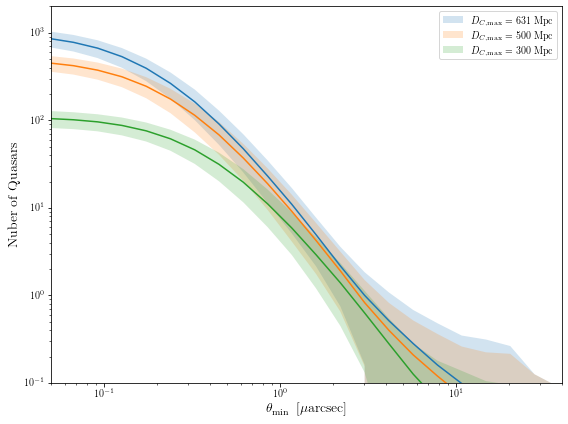

In [92]:
fig, ax = plt.subplots(figsize=(8, 6), tight_layout=True)

ax.loglog(theta_logs,np.mean(arr_theta_700,axis=1))
ax.fill_between(theta_logs,np.mean(arr_theta_700,axis=1)+np.std(arr_theta_700,axis=1),np.mean(arr_theta_700,axis=1)-np.std(arr_theta_700,axis=1), alpha=0.2,
                label=r'$D_{C,\rm{max}}=631\;\rm{Mpc}$')

ax.loglog(theta_logs,np.mean(arr_theta_500,axis=1))
ax.fill_between(theta_logs,np.mean(arr_theta_500,axis=1)+np.std(arr_theta_500,axis=1),np.mean(arr_theta_500,axis=1)-np.std(arr_theta_500,axis=1), alpha=0.2,
                label=r'$D_{C,\rm{max}}=500\;\rm{Mpc}$')

ax.loglog(theta_logs,np.mean(arr_theta_300,axis=1))
ax.fill_between(theta_logs,np.mean(arr_theta_300,axis=1)+np.std(arr_theta_300,axis=1),np.mean(arr_theta_300,axis=1)-np.std(arr_theta_300,axis=1), alpha=0.2,
                label=r'$D_{C,\rm{max}}=300\;\rm{Mpc}$')

plt.xlim(.05,40)
plt.ylim(.1,2*10**3)

plt.ylabel(r'$\rm{Nuber\;of\;Quasars}$', fontsize=14)
plt.xlabel(r'$\theta_{\rm min}\;\left[\mu{\rm arcsec}\right]$', fontsize=14)

ax.legend(loc='upper right',fontsize=10) 

plt.show()

In [97]:
volvol=vol_1(200)
N_rmax=np.zeros(len(theta_logs))
S_rmax=np.zeros(len(theta_logs))
N_temp=np.zeros(len(dist_lis))
S_temp=np.zeros(len(dist_lis))
for i,x in enumerate(tqdm(theta_logs)):
    temp=Ri_theta(x,rmax)
    for j,y in enumerate(tqdm(dist_lis,leave=False)):
        temp3,temp2=co_vol_23(200,temp,y,QQ_dsit)
        N_temp[j]=np.sum(temp2)/volvol
        S_temp[j]=2*np.sum(temp3)/volvol
    N_rmax[i]=np.mean(N_temp)
    S_rmax[i]=np.mean(S_temp)


In [104]:
N_rmax=N_rmax*vol_1(50)/vol_1(200)
S_rmax=S_rmax*vol_1(50)/vol_1(200)
DN_rmax=np.sqrt(S_rmax+N_rmax-N_rmax**2)

In [110]:
N_rmax/DN_rmax

array([1.38620277, 1.37146307, 1.35591086, 1.32947209, 1.28712923,
       1.23224432, 1.15011671, 1.06434043, 0.97148307, 0.88828636,
       0.81142572, 0.75027965, 0.69577604, 0.66208998, 0.63861154,
       0.60631698, 0.59275989, 0.54485069, 0.5287283 , 0.42774686,
       0.42315082, 0.35639545, 0.31944945, 0.28894792, 0.24498332,
       0.14955307, 0.09367911, 0.07286177, 0.04959717, 0.03037168])

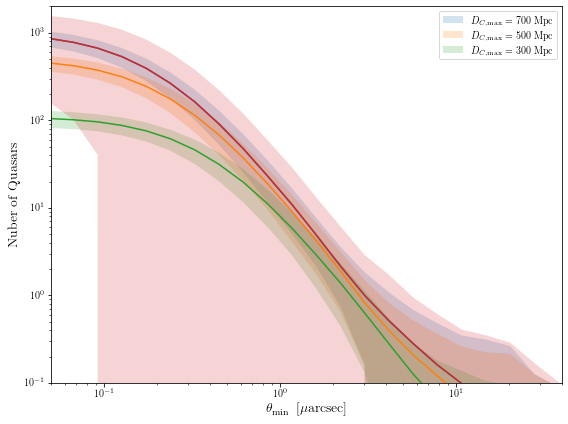

In [109]:
ig, ax = plt.subplots(figsize=(8, 6), tight_layout=True)

ax.loglog(theta_logs,np.mean(arr_theta_700,axis=1))
ax.fill_between(theta_logs,np.mean(arr_theta_700,axis=1)+np.std(arr_theta_700,axis=1),np.mean(arr_theta_700,axis=1)-np.std(arr_theta_700,axis=1), alpha=0.2,
                label=r'$D_{C,\rm{max}}=700\;\rm{Mpc}$')

ax.loglog(theta_logs,np.mean(arr_theta_500,axis=1))
ax.fill_between(theta_logs,np.mean(arr_theta_500,axis=1)+np.std(arr_theta_500,axis=1),np.mean(arr_theta_500,axis=1)-np.std(arr_theta_500,axis=1), alpha=0.2,
                label=r'$D_{C,\rm{max}}=500\;\rm{Mpc}$')

ax.loglog(theta_logs,np.mean(arr_theta_300,axis=1))
ax.fill_between(theta_logs,np.mean(arr_theta_300,axis=1)+np.std(arr_theta_300,axis=1),np.mean(arr_theta_300,axis=1)-np.std(arr_theta_300,axis=1), alpha=0.2,
                label=r'$D_{C,\rm{max}}=300\;\rm{Mpc}$')

ax.loglog(theta_logs,N_rmax)
ax.fill_between(theta_logs,N_rmax+DN_rmax,N_rmax-DN_rmax,alpha=0.2)

plt.xlim(.05,40)
plt.ylim(.1,2*10**3)

plt.ylabel(r'$\rm{Nuber\;of\;Quasars}$', fontsize=14)
plt.xlabel(r'$\theta_{\rm min}\;\left[\mu{\rm arcsec}\right]$', fontsize=14)

ax.legend(loc='upper right',fontsize=10) 

plt.show()

# Distance

In [84]:
dist_logs=np.logspace(0,np.log10(750),30)

arr_dist_p1=np.ones((len(dist_logs),len(dist_lis)))
for i,x in enumerate(tqdm(dist_logs)):
    temp=Ri_theta(.1,x)
    arr_dist_p1[i]=np.array([np.sum(co_volume_2_cases(800-x,temp,j)/(4*np.pi*(800-x)**3/3)) for j in (dist_lis)])
    
arr_dist_1=np.ones((len(dist_logs),len(dist_lis)))
for i,x in enumerate(tqdm(dist_logs)):
    temp=Ri_theta(1,x)
    arr_dist_1[i]=np.array([np.sum(co_volume_2_cases(800-x,temp,j)/(4*np.pi*(800-x)**3/3)) for j in (dist_lis)])
    
    
arr_dist_10=np.ones((len(dist_logs),len(dist_lis)))
for i,x in enumerate(tqdm(dist_logs)):
    temp=Ri_theta(10,x)
    arr_dist_10[i]=np.array([np.sum(co_volume_2_cases(800-x,temp,j)/(4*np.pi*(800-x)**3/3)) for j in (dist_lis)])


ValueError: operands could not be broadcast together with shapes (2568,) (38928,) 

In [83]:
dd=np.diff(np.log10(dist_logs))[0]
dist_logs_diff=np.sqrt(dist_logs[1:]*dist_logs[:-1])
arr_diff_dist_p1=np.diff(arr_dist_p1,axis=0)/dd
arr_diff_dist_1=np.diff(arr_dist_1,axis=0)/dd
arr_diff_dist_10=np.diff(arr_dist_10,axis=0)/dd

fig, ax = plt.subplots(figsize=(8, 6), tight_layout=True)

ax.loglog(dist_logs_diff,np.mean(arr_diff_dist_p1,axis=1))
ax.fill_between(dist_logs_diff,np.mean(arr_diff_dist_p1,axis=1)+np.std(arr_diff_dist_p1,axis=1),np.mean(arr_diff_dist_p1,axis=1)-np.std(arr_diff_dist_p1,axis=1), alpha=0.2,
                label=r'$\theta_{\rm min}=0.1\;\mu{\rm arcsec}$')

ax.loglog(dist_logs_diff,np.mean(arr_diff_dist_1,axis=1))
ax.fill_between(dist_logs_diff,np.mean(arr_diff_dist_1,axis=1)+np.std(arr_diff_dist_1,axis=1),np.mean(arr_diff_dist_1,axis=1)-np.std(arr_diff_dist_1,axis=1), alpha=0.2,
                label=r'$\theta_{\rm min}=1\;\mu{\rm arcsec}$')

ax.loglog(dist_logs_diff,np.mean(arr_diff_dist_10,axis=1))
ax.fill_between(dist_logs_diff,np.mean(arr_diff_dist_10,axis=1)+np.std(arr_diff_dist_10,axis=1),np.mean(arr_diff_dist_10,axis=1)-np.std(arr_diff_dist_10,axis=1), alpha=0.2,
                label=r'$\theta_{\rm min}=10\;\mu{\rm arcsec}$')

plt.xlim(1,600)
plt.ylim(10**(-4),2*10**3)

plt.ylabel(r'$\rm{dN_{QSO}/d\log_{10}D_C}$', fontsize=14)
plt.xlabel(r'$D_{C,\rm{max}}\;\left[\rm{Mpc}\right]$', fontsize=14)

ax.legend(loc='upper left',fontsize=10) 

plt.show()

NameError: name 'arr_dist_1' is not defined

# Random Arrays

# Import random crap

In [6]:
r_max=700 #Mpc
z_rmax=z_at_value(cosmo.comoving_distance,r_max*u.Mpc)

ran_dist_lis=np.loadtxt('./data/ran_dist_700.csv',delimiter=',')
ran_dec_lis=np.loadtxt('./data/ran_dec_700.csv',delimiter=',')
ran_ra_lis=np.loadtxt('./data/ran_ra_700.csv',delimiter=',')

# rand_cords=np.array([SkyCoord(ran_ra_lis[i]*u.degree, ran_dec_lis[i]*u.degree, frame='icrs', distance = x*u.Mpc) for i,x in enumerate(tqdm(ran_dist_lis[:200000]))])

In [7]:

OBS_car=Rvec(ran_dist_lis,ran_dec_lis*np.pi/180,ran_ra_lis*np.pi/180)[:25000]

In [8]:
np.savetxt('./data/QSO_x.csv',QSO_car[:,0])
np.savetxt('./data/QSO_y.csv',QSO_car[:,1])
np.savetxt('./data/QSO_z.csv',QSO_car[:,2])

In [58]:
# ran_ball_100Mpc=np.loadtxt('./data/ran_ball_100.csv',delimiter=',');
# ran_ball_car=Rvec(ran_ball_100Mpc[:,0],ran_ball_100Mpc[:,1]*np.pi/180,ran_ball_100Mpc[:,2]*np.pi/180);
# ran_ball_pos=np.loadtxt('./data/ran_ball_pos.csv',delimiter=',')
# OBS_ball_arr=np.array([ran_ball_car+x for x in ran_ball_pos])
OBS_ball_long=np.loadtxt('./data/ball_100_car.csv',delimiter=',')

In [60]:
OBS_ball_long.shape

(250000, 3)

In [10]:
from scipy.spatial.distance import cdist

rand_dist=cdist(OBS_car,QSO_car)
# rand_dist=cdist(OBS_ball_long,QSO_car)

# rand_dist=np.array([(x.separation_3d(QSO_coord).value) for x in tqdm(rand_cords)])



In [11]:
# A boolean array that tells you when a rnadom point and a quasrs are less than r_max appart.
rand_N=len(rand_dist[:,1])

dist_bool=np.array([rand_dist[i,:]<r_max for i in trange(rand_N)])